# IMDB Review
Given a IMDB movie review, classify it as positive or negative. Basically, it is a sentiment analysis.  

For doing so, I have used Bidirectional LSTM with Attention for better understanding the context of the review.  

This notebook is divided into the following sections:
* Importing the libraries
* Importing the dataset
* Text Preprocessing
* Attention
* Building the model
* Training
* Testing
***
### Importing the libraries
The cell below is for importing the required libraries and for silencing the warnings

In [37]:
# pip install --upgrade pip

In [1]:
!pip install pyvi

     |████████████████████████████████| 8.5MB 4.2MB/s eta 0:00:01
     |████████████████████████████████| 440kB 46.5MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/40/fa/ee/3afb15958ad26f3aef88d61c316b4d1af8a97660aa24e6e6d7
Successfully built python-crfsuite


In [39]:
# !pip install keras tensorflow

In [3]:
#Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.pooling import GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import *
from keras import backend
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf

from pyvi import ViTokenizer
from pyvi import ViUtils

Using TensorFlow backend.


In [5]:

import re
import string
import codecs

In [6]:

#Từ điển tích cực, tiêu cực, phủ định
path_nag = '/kaggle/input/sentimentnew/nag.txt'
path_pos = '/kaggle/input/sentimentnew/pos.txt'
path_not = '/kaggle/input/sentimentnew/not.txt'

with codecs.open(path_nag, 'r', encoding='UTF-8') as f:
    nag = f.readlines()
nag_list = [n.replace('\n', '') for n in nag]

with codecs.open(path_pos, 'r', encoding='UTF-8') as f:
    pos = f.readlines()
pos_list = [n.replace('\n', '') for n in pos]
with codecs.open(path_not, 'r', encoding='UTF-8') as f:
    not_ = f.readlines()
not_list = [n.replace('\n', '') for n in not_]


VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER

### Importing the dataset
***

The dataset: 'imdb_master.csv' is read and loaded as pandas dataframe.  
Let's have a look at the data

In [7]:
#Importing the dataset

dataset = pd.read_csv('/kaggle/input/dataaaa/data.csv')
dataset.head()

,Comment,Rating
0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1.0
1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0.0
2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1.0
3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0.0
4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1.0


The columns which are not essential are removed.   
Unlabeled reviews are removed and the class names are converted to numerical digits: 1 for positive and 0 for negative.
The dataset is now split into Training set and Test set

In [16]:
df = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/full_train.csv')
data_train = pd.DataFrame({'input':df['Comment'],'label':df['Rating']})
data_train = data_train.dropna()
data_train = data_train.reset_index(drop=True)
X_train = data_train['input'].values
y_train = data_train['label'].values

In [12]:
y_train

array([1., 0., 1., ..., 0., 0., 0.])

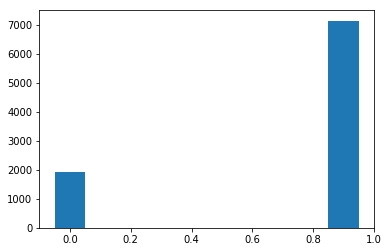

In [17]:
plt.hist(y_train,rwidth = 2,align ="left")
plt.savefig('demo.png')

In [45]:
# my_data_new = pd.DataFrame({'RevId': np.array(df["RevId"]).reshape(5103), 'Rating': np.array(y_pred).reshape(5103)})
# you could use any filename. We choose submission here
data_train.to_excel('my_data_new.xlsx', index=False)

In [46]:
# X_train

In [47]:
# np.savetxt('data_text.txt', X_train, fmt='%s')

In [48]:
print(np.shape(X_train))
print(np.shape(y_train))

(59070,)
(59070,)


In [49]:
# #Splitting into training and test set
# dataset = dataset.drop(['Unnamed: 0', 'file'], axis = 1)
# dataset = dataset[dataset.label != 'unsup']
# dataset['label'] = dataset['label'].map({'pos': 1, 'neg': 0})
# dataset_test = dataset[dataset['type'] == 'test']
# dataset_train = dataset[dataset['type'] == 'train']
# # X_test = dataset_test.iloc[:, 1:2].values
# # y_test = dataset_test.iloc[:, 2].values
# X_train = dataset_train.iloc[:, 1:2].values
# y_train = dataset_train.iloc[:, 2].values

### Text Preprocessing
***
Preprocessing the text so as to have a better data for our model.  
It comprises of steps such as removing non-ASCII characters, removing HTML tags, converting to lower-case, lemmatizing.

In [50]:
def normalize_text(text):

   #Remove các ký tự kéo dài: vd: đẹppppppp
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    # Chuyển thành chữ thường
    text = text.lower()

    #Chuẩn hóa tiếng Việt, xử lý emoj, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        #Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
        "👹": "  tệ", "👻": " ngon", "💃": " ngon",'🤙': '  ngon ', '👍': '  ngon ',
        "💄": " ngon", "💎": " ngon", "💩": " ngon","😕": "  tệ", "😱": "  tệ", "😸": " ngon",
        "😾": "  tệ", "🚫": "  tệ",  "🤬": "  tệ","🧚": " ngon", "🧡": " ngon",'🐶':'  ngon ',
        '👎': '   tệ ', '😣': '   tệ ','✨': '  ngon ', '❣': '  ngon ','☀': '  ngon ',
        '♥': '  ngon ', '🤩': '  ngon ', 'like': '  ngon ', '💌': '  ngon ',
        '🤣': '  ngon ', '🖤': '  ngon ', '🤤': '  ngon ', ':(': '   tệ ', '😢': '   tệ ',
        '❤': '  ngon ', '😍': '  ngon ', '😘': '  ngon ', '😪': '   tệ ', '😊': '  ngon ',
        '?': ' ? ', '😁': '  ngon ', '💖': '  ngon ', '😟': '   tệ ', '😭': '   tệ ',
        '💯': '  ngon ', '💗': '  ngon ', '♡': '  ngon ', '💜': '  ngon ', '🤗': '  ngon ',
        '^^': '  ngon ', '😨': '   tệ ', '☺': '  ngon ', '💋': '  ngon ', '👌': '  ngon ',
        '😖': '   tệ ', '😀': '  ngon ', ':((': '   tệ ', '😡': '   tệ ', '😠': '   tệ ',
        '😒': '   tệ ', '🙂': '  ngon ', '😏': '   tệ ', '😝': '  ngon ', '😄': '  ngon ',
        '😙': '  ngon ', '😤': '   tệ ', '😎': '  ngon ', '😆': '  ngon ', '💚': '  ngon ',
        '✌': '  ngon ', '💕': '  ngon ', '😞': '   tệ ', '😓': '   tệ ', '️🆗️': '  ngon ',
        '😉': '  ngon ', '😂': '  ngon ', ':v': '   ngon ', '=))': '   ngon ', '😋': '  ngon ',
        '💓': '  ngon ', '😐': '   tệ ', ':3': '  ngon ', '😫': '   tệ ', '😥': '   tệ ',
        '😃': '  ngon ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': '  ngon ', '🤝': '  ngon ', '🎈': '  ngon ',
        '😗': '  ngon ', '🤔': '   tệ ', '😑': '   tệ ', '🔥': '   tệ ', '🙏': '   tệ ',
        '🆗': '  ngon ', '😻': '  ngon ', '💙': '  ngon ', '💟': '  ngon ',
        '😚': '  ngon ', '❌': '   tệ ', '👏': '  ngon ', ';)': '  ngon ', '<3': '  ngon ',
        '🌝': '  ngon ',  '🌷': '  ngon ', '🌸': '  ngon ', '🌺': '  ngon ',
        '🌼': '  ngon ', '🍓': '  ngon ', '🐅': '  ngon ', '🐾': '  ngon ', '👉': '  ngon ',
        '💐': '  ngon ', '💞': '  ngon ', '💥': '  ngon ', '💪': '  ngon ',
        '💰': '  ngon ',  '😇': '  ngon ', '😛': '  ngon ', '😜': '  ngon ',
        '🙃': '  ngon ', '🤑': '  ngon ', '🤪': '  ngon ','☹': '   tệ ',  '💀': '   tệ ',
        '😔': '   tệ ', '😧': '   tệ ', '😩': '   tệ ', '😰': '   tệ ', '😳': '   tệ ',
        '😵': '   tệ ', '😶': '   tệ ', '🙁': '   tệ ',
        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '   ngon ', ':)': '  ngon ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u'  ngon ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': '  ngon ','hehe': '  ngon ','hihi': '  ngon ', 'haha': '  ngon ', 'hjhj': '  ngon ',
        ' lol ': '   tệ ',' cc ': '   tệ ','cute': u' dễ thương ','huhu': '   tệ ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u'  ngon ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u'  ngon ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',}

    for k, v in replace_list.items():
        text = text.replace(k, v)

    # chuyen punctuation thành space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)

    text = ViTokenizer.tokenize(text)
    texts = text.split()
    len_text = len(texts)

    texts = [t.replace('_', ' ') for t in texts]
    for i in range(len_text):
        cp_text = texts[i]
        if cp_text in not_list: # Xử lý vấn đề phủ định (VD: áo này chẳng đẹp--> áo này notpos)
            numb_word = 2 if len_text - i - 1 >= 4 else len_text - i - 1

            for j in range(numb_word):
                if texts[i + j + 1] in pos_list:
                    texts[i] = 'không ngon'
                    texts[i + j + 1] = ''

                if texts[i + j + 1] in nag_list:
                    texts[i] = 'không tệ'
                    texts[i + j + 1] = ''
        else: #Thêm feature cho những sentiment words (áo này đẹp--> áo này đẹp  ngon)
            if cp_text in pos_list:
                texts.append(' ngon')
            elif cp_text in nag_list:
                texts.append('  tệ')

    text = u' '.join(texts)

    #remove nốt những ký tự thừa thãi
    text = text.replace(u'"', u' ')
    text = text.replace(u'️', u'')
    text = text.replace('🏻','')

    return text


In [51]:
text =  'dù ăn_ở quán hay order về đều mê lớm 😍 thích nhất là sốt sì dầu ăn vừa_miệng sốt cay ngọt ăn nhiều sẽ hơi ngán nma vẫn cứ rất ô_kê 2 phần gà một phần cơm bao no_đủ 4 người nha đóng_gói kĩ sạch_sẽ giá_thành thì hợp_lí so với chất_lượng ngon hơn nhiều so với nhiều quán gà hàn quốc khác nên thử'

In [52]:
d = [text]

In [53]:
e = [1]

In [54]:
normalize_text(text)

'dù ăn ở quán hay đặt hàng về đều mê lớm ngon thích nhất là sốt sì dầu ăn vừa miệng sốt cay ngọt ăn nhiều sẽ hơi ngán nma vẫn cứ rất ô kê 2 phần gà một phần cơm bao no đủ 4 người nha đóng gói kĩ sạch sẽ giá thành thì hợp lí so với chất lượng ngon hơn nhiều so với nhiều quán gà hàn quốc khác nên thử  ngon  ngon   tệ  ngon  ngon  ngon  ngon  ngon'

In [55]:
#Function for Text Preprocessing
# stop_words = set(stopwords.words("english")) 
# lemmatizer = WordNetLemmatizer()

def clean_text(X,y):
    idx = 0
    y_train = []
    processed = []
    for text in X:
#         print(text)
#         text = normalize_text(text)
#         text = text[0]
#         text = re.sub(r'[^\w\s]','',text, re.UNICODE)
#         text = re.sub('<.*?>', '', text)
#         text = text.lower()
#         text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
#         text = [lemmatizer.lemmatize(token, "v") for token in text]
#         text = [word for word in text if not word in stop_words]
        text = list(tf.keras.preprocessing.text.text_to_word_sequence(text))
        text = " ".join(text)
        input_text_pre_no_accent = str(ViUtils.remove_accents(text).decode("utf-8"))
        input_text_pre_accent = ViTokenizer.tokenize(text)
#         print("vi tokenizer text: ", input_text_pre_accent)
        input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
        processed.append(input_text_pre_accent)
        processed.append(input_text_pre_no_accent)
        y_train.append(y[idx])
        y_train.append(y[idx])
#         processed.append(text)
        idx += 1
    return processed,y_train

In [56]:
print()

Preprocessing the Training Set and Test set

In [57]:
X_train_final,y_train = clean_text(X_train,y_train)
# X_test_final,y_test = clean_text(X_test,y_test)

In [58]:
print(np.shape(X_train_final))
print(np.shape(y_train))

(118140,)
(118140,)


### Attention Layer
***

The basic concept of attention is that not all words contribute equally to the meaning of a sentence. Hence, their contribution must be weighted.  
How attention works is, it basically extracts words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector.

In [59]:
# Attention Layer
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

Some Useful Variables  


In [60]:
#Tokenization and Padding
vocab_size = 60000
maxlen = 250
encode_dim = 20
batch_size = 32
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_final)
tokenized_word_list = tokenizer.texts_to_sequences(X_train_final)
X_train_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')

In [61]:
# tokenizer.word_index

In [62]:
print(np.shape(X_train_padded))
print(np.shape(X_train_final))

(118140, 250)
(118140,)


**EarlyStopping**  
It can be used to prevent overfitting.It basically waits a few epochs (5), monitoring the loss for the validation dataset.If the loss doesn't decrease for 2 epochs, it stops the training process.

**ModelCheckpoint**  
It is used for saving the best model during training. After each epoch, it takes a look at the Validation accuracy, if it improves globally, this is the best model we have seen till now during the training process and hence, saves it.

In [63]:
#EarlyStopping and ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
# es = EarlyStopping(monitor = 'val_loss', patience = 6)
mc = ModelCheckpoint('model_best.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

### Building the Model
***
The model used comprises of BiDirectional LSTM with Attention layer on top of it, followed by a dense layer and finally a dense layer with sigmoid activation function to get the sentiment or the class.  
Optimiser used is ADAM

In [64]:
#Building the model
model = Sequential()
embed = Embedding(input_dim = vocab_size, output_dim = 20, input_length = X_train_padded.shape[1], dropout = 0.4) 
model.add(embed)
model.add(Bidirectional(CuDNNLSTM(200, return_sequences = True)))

model.add(Dropout(0.3))
model.add(AttentionWithContext())
model.add(Dropout(0.5))
model.add(Dense(512))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 20)           1200000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 400)          355200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 400)          0         
_________________________________________________________________
attention_with_context_1 (At (None, 400)               160800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               205312    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

### Training
***
Splitting the Training set into Training set and Validation set

In [65]:
from sklearn.model_selection import train_test_split
X_train_final2, X_val, y_train_final2, y_val = train_test_split(X_train_padded, y_train, test_size = 0.2)

Training the model

In [66]:
#Fitting the model
model.fit(X_train_final2, y_train_final2, epochs = 50, batch_size = batch_size, verbose = 1, validation_data = [X_val, y_val], callbacks = [es, mc])

# model.fit(X_train_final2, y_train_final2, epochs = 13, batch_size = batch_size, verbose = 1, validation_data = [X_val, y_val])

Train on 94512 samples, validate on 23628 samples
Epoch 1/50
94512/94512 [==============================] - 385s 4ms/step - loss: 0.3427 - acc: 0.8572 - val_loss: 0.3203 - val_acc: 0.8750

Epoch 00001: val_acc improved from -inf to 0.87502, saving model to model_best.h5
Epoch 2/50
94512/94512 [==============================] - 375s 4ms/step - loss: 0.2741 - acc: 0.8930 - val_loss: 0.2876 - val_acc: 0.8897

Epoch 00002: val_acc improved from 0.87502 to 0.88966, saving model to model_best.h5
Epoch 3/50
94512/94512 [==============================] - 376s 4ms/step - loss: 0.2459 - acc: 0.9048 - val_loss: 0.2671 - val_acc: 0.8949

Epoch 00003: val_acc improved from 0.88966 to 0.89487, saving model to model_best.h5
Epoch 4/50
94512/94512 [==============================] - 376s 4ms/step - loss: 0.2200 - acc: 0.9150 - val_loss: 0.2719 - val_acc: 0.8941

Epoch 00004: val_acc did not improve from 0.89487
Epoch 5/50
94512/94512 [==============================] - 375s 4ms/step - loss: 0.1988 - acc

### Testing
***
Converting the test data into sequences of integers and padding them.  
Loading the best model and calculating the accuracy

In [67]:
df = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/test.csv')
data_test = pd.DataFrame({'input':df['Comment'],'id':df["RevId"]})
# data_test = data_test.dropna()
# data_test = data_test.reset_index(drop=True)
X_test = data_test['input'].values

def clean_text_test(X):
    processed = []
    for text in X:
        text = normalize_text(str(text))
        text = list(tf.keras.preprocessing.text.text_to_word_sequence(str(text)))
        text = " ".join(text)
        input_text_pre_no_accent = str(ViUtils.remove_accents(text).decode("utf-8"))
        input_text_pre_accent = ViTokenizer.tokenize(text)
        processed.append(input_text_pre_accent)
    return processed

X_test_final = clean_text_test(X_test)

tokenized_word_list = tokenizer.texts_to_sequences(X_test_final)
X_test_padded = pad_sequences(tokenized_word_list, maxlen = maxlen, padding='post')


In [68]:
X_test_final[32]

'quán bé nhưng vô_cùng đắt hàng nha_tệ'

In [69]:
print(X_test_final[9])

quá trưa định đi thử phở thìn ở lò_đúc cơ nhưng mà đường xa mỏi gối thế quái nào lại sà vào cái quán này gà tần 55k không nhớ 55k hay 65k gì đấy thêm mì gói trần nước sôi 10k được cái là gà_ác nhưng tần rất ít vị thuốc ngải_cứu cũng chỉ được 1 tẹo nước cũng chỉ được 1 tí có_lẽ vì con gà đã chiếm hết diện_tích ống_bơ gà đã tần sẵn để trong ống_bơ khách gọi mới trần lại cho âm_ấm xong đổ ra bát 1 đống trông rất mất cảm_tình cá_nhân mình thấy vị dở vô_cùng dở ngon tệ ngon ngon tệ tệ


In [70]:
print(X_train[3551])

Thơm, sạch sẽ


In [71]:
print(y_train[3551])

1.0


In [72]:
print(X_test_final[12])

tôi vừa đặt 1 xuất cơm vịt mất 70 trên now nhưng cửa_hàng lại quên không cho vịt vào


In [73]:
print(X_test_final[391])

ăn bánh_mì ở quán 3 4 lần rồi mà hnay mới review được ưu_điểm đầu_tiên phải kể đến là giá_cả rất ok 4k 1 cái so với mặt_bằng chung ở hn là hợp_lý rồi thứ hai là bánh ăn rất thơm mình thích ăn mềm mềm bạn mình lại thích ăn giòn nên toàn mua 5 nọ 5 kia pate ngon 1 cái bé bé xinh_xinh nên ăn_không ngán thứ 3 là cái xe bán bánh_mì màu rất đẹp ngon vì mình thích màu vàng nhìn từ xa cái thấy luôn nổi_bật thôi rồi nhân_viên bán hàng nhiệt_tình vui_tính rất hài_lòng vì dịch_vụ tại quán nói_chung rất ưng à còn có pate bán ngoài pate ngon dã_man cả nhà mình ai cũng khen suốt nên toàn đặt luôn 10 hộp ngon m n nên thử nhé ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon ngon tệ ngon ngon


In [74]:
# y_pred[12]

In [75]:
import tensorflow as tf
# from tensorflow import keras
import keras

model = keras.models.load_model('/kaggle/working/model_best.h5', custom_objects={'AttentionWithContext': AttentionWithContext} )
y_pred = model.predict(X_test_padded)

In [79]:
my_submission = pd.DataFrame({'RevId': np.array(df["RevId"]).reshape(5103), 'Rating': np.array(y_pred).reshape(5103)})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_0912_b.csv', index=False)

In [77]:
# df = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/test.csv')
# data_test = pd.DataFrame({'input':df['Comment'],'id':df["RevId"]})
# # data_test = data_test.dropna()
# # data_test = data_test.reset_index(drop=True)
# X_test = data_test['input'].values

In [78]:
# my_test_data = pd.DataFrame({'RevId': np.array(df["RevId"]).reshape(5103),'input':df['Comment'],  'Rating': np.array(y_pred).reshape(5103)})
# my_test_data.to_excel('my_test_data_predicted.xlsx', index=False)